To begin, download the file SC_data_CleanedUp.csv and set your working directory. If not already installed, install the dplyr and ade4 R packages for data manipulation and clustering.

In [15]:
data <- read.csv("SC_data_CleanedUp.csv")

install.packages("dplyr")
library(dplyr)

install.packages("ade4")
library(ade4)

Warning message:
"package 'dplyr' is in use and will not be installed"Warning message:
"package 'ade4' is in use and will not be installed"

Aggregate to the customer-trip level and confirm aggregation was successful by testing if the to-be-created "customer_data" is a data frame.

In [16]:
customer_data <- data%>% 
  group_by(PNRLocatorID,CustID)%>%
  summarise(PaxName = first(PaxName),
            BookingChannel = first(BookingChannel), 
            amt = max(TotalDocAmt), 
            UFlyRewards = first(UFlyRewardsNumber), 
            UflyMemberStatus = first(UflyMemberStatus), 
            age_group = first(age_group), 
            true_origin = first(true_origin), 
            true_destination = first(true_destination), 
            round_trip = first(round_trip), 
            group_size = first(group_size), 
            group = first(group), 
            seasonality = first(Seasonality), 
            days_pre_booked = max(days_pre_booked))

is.data.frame(customer_data)

dim(customer_data)

[1] TRUE

[1] 17946    15

Remove unnecessary variables (encrypted names, customer IDs, etc.). Normalize the amt, days_pre_booked, and group_size variables.

In [17]:
clustering_data <- subset(customer_data,select = -c(PNRLocatorID,CustID,PaxName,UFlyRewards))

normalize <- function(x){
  return ((x - min(x))/(max(x) - min(x)))}

clustering_data = mutate(clustering_data,
            amt = normalize(amt),
            days_pre_booked = normalize(days_pre_booked), 
            group_size = normalize(group_size))

Since the k-means clustering algorithm works only with numerical data, we need to convert each of the categorical factor levels into numerical dummy variables ("0" or "1"). The ade4 package will be used to convert the categorical data into these numerical dummy variables.

In [18]:
clustering_data <- as.data.frame(clustering_data)
clustering_data <- clustering_data %>% 
  cbind(acm.disjonctif(clustering_data[,c("BookingChannel","age_group","true_origin","true_destination",
                                          "UflyMemberStatus","seasonality")])) %>% ungroup()

#For cleanliness, remove the original, non-dummy-coded variables.
clustering_data<-clustering_data %>% select(-BookingChannel,-age_group,-true_origin,-true_destination,-UflyMemberStatus,-seasonality)

Now we can run k-means to gain a better understanding at the within SSE curve. We'll analyze SSE while comparing the impact on SSE from 1 to 15 clusters.

_Note: The sum of squared errors (or "SSE") is the sum of the squared differences between each observation and its cluster's mean. In the context of this clustering analysis, SSE is used as a measure of variation. If all observations within a cluster are identical, the SSE would be equal to 0. Modeling for "the lowest SSE possible" is not ideal as this results in model overfitting._

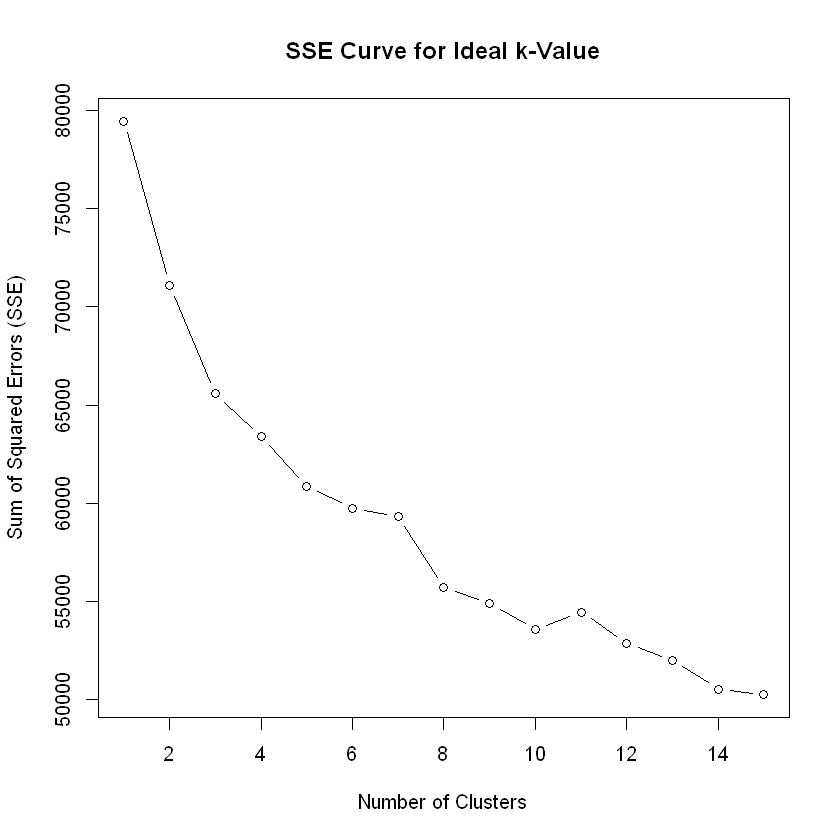

In [26]:
SSE_curve <- c()
for (n in 1:15) {
  kcluster <- kmeans(clustering_data, n)
  sse <- sum(kcluster$withinss)
  SSE_curve[n] <- sse
}

plot(1:15, SSE_curve, type="b", main="SSE Curve for Ideal k-Value", xlab="Number of Clusters", ylab="Sum of Squared Errors (SSE)")

Given the plot above, the change in SSE decreases significantly after ~5 clusters. Let's select 5 clusters for the purpose of this customer segmentation.

In [24]:
kcluster<- kmeans(clustering_data, 5)

print("The following represents the size of each cluster:")
kcluster$size

[1] "The following represents the size of each cluster:"


[1] 2748 4339 2643 5238 2978

Lastly, add a new column with the cluster assignment into the CSV file, and call this field "Segment", for each observation in customer_data. After running the code below, this analysis will be completed.

In [25]:
segment <- as.data.frame(kcluster$cluster)
colnames(segment) <- "Segment" 
customer_segment_data <- cbind.data.frame(customer_data, segment)
write.csv(customer_segment_data, "SC_customer_segment_data.csv")